# Check Algorithm Profits

In [179]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
def trasform_ratios_to_probs(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        df_copy[column] = (1/df_copy[column])
    normalization_factor = df_copy.sum(axis = 1)
    for column in df_copy.columns:
        df_copy[column] /= normalization_factor
    return df_copy

def get_naive_predictions(df):
    return pd.Series(np.array(df).argmax(axis = 1),index = df.index)

def calc_rolling_mean(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).mean())[0:-1]
    return pd.Series(temp_list,index = series.index)

def calc_rolling_sum(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).sum())[0:-1]
    return pd.Series(temp_list,index = series.index)

def get_optimal_bet_ratio(df,bet_houses,pred):
    dic = {0:"D",1:"H",2:"A"}
    temp_pred = pred.map(dic)
    temp = []
    for index in temp_pred.index:
        new_list = [x + temp_pred.at[index] for x in bet_houses]
        temp.append(df.loc[index][new_list].max())
    return pd.Series(temp,index = df.index)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [181]:
matches = pd.read_csv("databases/my_matches_db.csv",encoding='latin-1', index_col = [0], skipinitialspace = True)
matches.head()

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.0,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.5,4.5,5.5,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.0,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.5,5.5,6.0,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.0,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.6,3.3,3.8,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.0,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.4,3.2,3.5,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.0,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.4,3.2,3.5,1


In [182]:
my_predictions = pd.read_csv("databases/my_predictions.csv", index_col = [0], skipinitialspace = True)
my_predictions.head()

,MYD,MYH,MYA
13411,0.420000,0.358333,0.221667
4804,0.335000,0.451667,0.213333
4476,0.303333,0.288333,0.408333
6602,0.183333,0.673333,0.143333
6937,0.185000,0.728333,0.086667


### Betting odds features

In [183]:
b365_features = ["B365D","B365H","B365A"]
wh_features   = ["WHD","WHH","WHA"]
vc_features   = ["VCD","VCH","VCA"]
my_features   = ["MYD","MYH","MYA"]

bet_houses    = ["B365","WH","VC"]

current_bet   = b365_features

In [184]:
matches[my_features] = my_predictions

In [185]:
new_matches = matches.dropna(axis = 0)

###  Features with nan values

In [186]:
max_bet_per_match = 500

In [187]:
matches_betting_odds_features = new_matches[current_bet].dropna(axis = 0)

if current_bet != my_features:
    matches_betting_odds_features = trasform_ratios_to_probs(matches_betting_odds_features)
    
new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

matches_betting_odds_features["predictions"] = new_matches["predictions"]
matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])


matches_betting_odds_features.head()

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,B365D,B365H,B365A,predictions,real_score,right_wrong,bet_ratio
141,0.288462,0.423077,0.288462,1,2,0,2.25
142,0.269726,0.494263,0.236011,1,2,0,2.00
143,0.249688,0.604340,0.145971,1,0,0,1.60
144,0.288136,0.432203,0.279661,1,0,0,2.20
148,0.263094,0.547479,0.189428,1,1,1,1.83


In [188]:
new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)

In [189]:
new_matches_betting_odds_features.head()

,B365D,B365H,B365A,right_wrong,bet_ratio
141,0.288462,0.423077,0.288462,0,2.25
142,0.269726,0.494263,0.236011,0,2.00
143,0.249688,0.604340,0.145971,0,1.60
144,0.288136,0.432203,0.279661,0,2.20
148,0.263094,0.547479,0.189428,1,1.83


In [190]:
calc_rolling_mean(new_matches_betting_odds_features,"right_wrong").tail()

14003    0.535113
14005    0.534958
14010    0.534803
14012    0.534938
14015    0.535072
dtype: float64

In [191]:
new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
new_lables   = new_matches_betting_odds_features["right_wrong"]

### Spliting the data 

In [192]:
from sklearn.model_selection import train_test_split

In [193]:
X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(new_features, new_lables, test_size = 0.30, random_state = 101)

In [194]:
X_train_outer.drop("bet_ratio",axis = 1,inplace = True)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [195]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = 101)

In [196]:
from sklearn.linear_model import LogisticRegression

In [197]:
logmodel = LogisticRegression()
logmodel.fit(X_train_inner,y_train_inner)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [198]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train_inner,y_train_inner)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [199]:
chosen_model = rfc
predictions  = chosen_model.predict(X_test_inner)

In [200]:
from sklearn.metrics import classification_report,confusion_matrix

In [201]:
printmd('**classification_report:**')
print(classification_report(y_test_inner,predictions))
printmd('**confusion_matrix:**')
print(confusion_matrix(y_test_inner,predictions))

**classification_report:**

             precision    recall  f1-score   support

          0       0.56      0.49      0.52       346
          1       0.58      0.65      0.61       379

avg / total       0.57      0.57      0.57       725



**confusion_matrix:**

[[170 176]
 [134 245]]


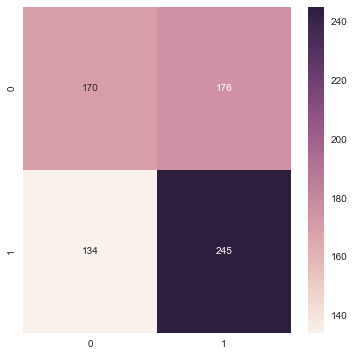

In [202]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_inner,predictions),annot=True, fmt="d")

In [203]:
coeff_df = pd.DataFrame(logmodel.coef_.T,X_train_inner.columns)
coeff_df

,0
B365D,-4.198150
B365H,2.362798
B365A,1.511591


In [204]:
def get_optimal_bet(df,model,max_bet):
    return pd.Series(np.maximum((model.predict_proba(df) - 0.5)*2,0).T[1] * max_bet,index = df.index)

In [205]:
X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),chosen_model,max_bet_per_match)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [206]:
X_test_outer["right_wrong"] = y_test_outer

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [207]:
X_test_outer.head()

,B365D,B365H,B365A,bet_ratio,bet,right_wrong
9710,0.134236,0.803121,0.062643,1.18,486.333333,1
12862,0.276886,0.313804,0.409310,2.50,0.000000,1
4337,0.275632,0.520639,0.203728,1.85,0.000000,1
8049,0.280245,0.388911,0.330844,2.50,0.000000,0
5186,0.198160,0.707714,0.094126,1.36,496.296296,1


In [208]:
games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]

In [209]:
calc_rolling_mean(games_worth_betting,"right_wrong").tail()

11714    0.623037
612      0.623693
3229     0.622609
5994     0.621528
11279    0.622184
dtype: float64

In [210]:
games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [211]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]

all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
all_bets[bet_info]               = games_worth_betting[bet_info]
all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

all_bets.reset_index(drop=True,inplace=True)

all_bets.head()

,season,stage,home_team_name,away_team_name,score,predictions,right_wrong,bet_ratio,bet,profit,profit_through_time,invest_through_time
0,2008/2009,16,Blackburn Rovers,Liverpool,1 - 3,2,1,1.73,238.861111,174.368611,0.000000,0.000000
1,2008/2009,16,Hull City,Middlesbrough,2 - 1,1,1,2.40,348.353646,487.695105,174.368611,238.861111
2,2008/2009,19,Stoke City,Manchester United,0 - 1,2,1,1.33,341.253968,112.613810,662.063716,587.214757
3,2008/2009,21,Fulham,Blackburn Rovers,1 - 2,1,0,2.25,25.535714,-25.535714,774.677526,928.468726
4,2008/2009,22,Sunderland,Aston Villa,1 - 2,2,1,2.25,67.847222,84.809028,749.141811,954.004440


In [212]:
print("Mean Bet             =", all_bets["bet"].mean(),"$")
print("Max  Bet             =", all_bets["bet"].max(),"$")
print("Min  Bet             =", all_bets["bet"].min(),"$","\n")
print("Mean Profit          =", all_bets["profit"].mean(),"$")
print("Max  Profit          =", all_bets["profit"].max(),"$")
print("Min  Profit          =", all_bets["profit"].min(),"$","\n")
print("Total Money Invested =", all_bets["bet"].sum(),"$")
print("Profits              =", all_bets["profit"].sum(),"$")
print("Profit Percentage    =",(all_bets["profit"].sum()/all_bets["bet"].sum())*100,"%")

Mean Bet             = 240.1853868473077 $
Max  Bet             = 500.0 $
Min  Bet             = 0.633597883598 $ 

Mean Profit          = 8.638799470500341 $
Max  Profit          = 637.870099206 $
Min  Profit          = -500.0 $ 

Total Money Invested = 138827.15359774386 $
Profits              = 4993.226093949197 $
Profit Percentage    = 3.59672150912006 %


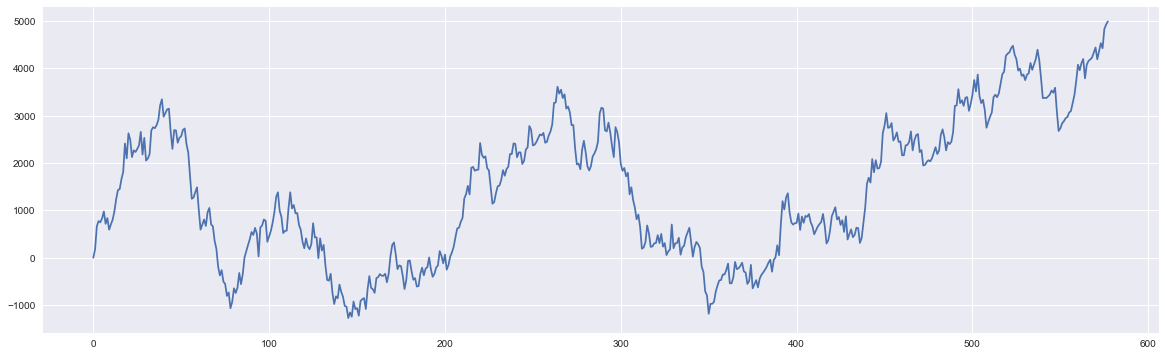

In [213]:
plt.figure(figsize=(20, 6))
plt.plot(all_bets.index,all_bets["profit_through_time"])